# Nutrition Datas: Extracting trends from our customers

<div class="alert alert-block alert-info">
Now we are done with scrapping nutrition values, we want to build the actual nutrition profile: in order to do so, we first need to first extract the mass of each article, in order to assess the total sold mass.
</div>

In [1]:
from __future__ import print_function

%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from matplotlib.ticker import MaxNLocator
import re
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
import sys
sys.path.insert(1, './utilities/')
import weight_functions as wf 
from tabulate import tabulate
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
product_df = pd.read_csv('../data/dunnhumby_data/product.csv')
transaction_data_df = pd.read_csv('../data/dunnhumby_data/transaction_data.csv')


## Limiting our dataset

In [3]:
food_related_arr = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT'])
#products related to food only
food_product_df = product_df.loc[(product_df['DEPARTMENT'].isin(food_related_arr))]
food_product_df = food_product_df[~food_product_df.COMMODITY_DESC.isin(['PAPER TOWELS','BATH TISSUES','LAUNDRY DETERGENTS','FD WRAPS/BAGS/TRSH BG']) ]

#transaction dataset related to food only
food_transaction_data = transaction_data_df.merge(food_product_df,how = 'inner',on = 'PRODUCT_ID')
food_transaction_data['dunn_name'] = food_transaction_data['COMMODITY_DESC'] + " " + food_transaction_data['SUB_COMMODITY_DESC']
food_transaction_data = food_transaction_data.drop(columns = ['COMMODITY_DESC','SUB_COMMODITY_DESC'])[['household_key','BASKET_ID','PRODUCT_ID','QUANTITY','CURR_SIZE_OF_PRODUCT','dunn_name']]

In [4]:
food_product_df[food_product_df.SUB_COMMODITY_DESC.str.contains('NON-CRBNTD DRNK')]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
168,32160,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,2.50 GA
304,35895,1208,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,33.8 OZ
390,39839,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,1 GA
1568,84208,1208,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,20 OZ
1972,100389,1208,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,.5 LTR
...,...,...,...,...,...,...,...
70111,9837404,103,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,144 OZ
71219,9993322,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,2416.9 OZ
72524,10256703,6231,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,5 GL
81320,13115723,103,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,20 OZ


<div class="alert alert-block alert-info">    
Ideally one want to have an idea of which items are consumed the most in terms of mass, unfortunately, the mass section presents a lot of different units which are not easily parsable.
</div>

In [5]:
#as we can see, there are a lot of different units
units = food_transaction_data.CURR_SIZE_OF_PRODUCT.unique()
index = np.random.choice(units.shape[0], 30, replace=False)  
units[index]

array(['3 OZ/10 QT', '200 CT', '8 PK/12 OZ', '2.55 OZ', '1 PINT',
       '.22 OZ', '4PK/3CC', '120CT/2PLY', '16.50 OZ', '4/10 OZ', '2.4 OZ',
       '8       OZ', '5.04 OZ', '12 3/8 OZ', '18.9 OZ', 'L     8 OZ',
       '1.64 OZ', '6 USE', '30.6 OZ', '2 CT/1 OZ', '25.85 OZ', '4.76 OZ',
       '3-3 OZ', '6.6 OZ', '.5 LTR', '4.50 OZ', '12PK/300OZ',
       'P     2 OZ', '16.65 OZ', '40 OZ'], dtype=object)

## Extracting the weight

<div class="alert alert-block alert-info">
The goal consists in extracting the weights to numerical values using regexes. Unfortunately, all units cannot be taken into account.
</div>

In [6]:
bad_units = food_transaction_data[~food_transaction_data.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].CURR_SIZE_OF_PRODUCT.unique()
print('List of units not treated by the regex: {}'.format(bad_units))

List of units not treated by the regex: ['60 LOAD' '40 LOAD' '10 INCH' 'LARGE' '1GL' '1 KIT' '34 LD' '4 INCH'
 '2 PACK' '80 USE' '40 LOADS' '60 LOADS' '6 USE' '3 PACK' '52 LD'
 '8-9 INCH' '60 GM' '7 IN' '60 LD' '3.5 INCH' '5.5 INCH' '1IN X 18IN'
 '1IN X 22IN' '5 PIECE' '5 INCH' '120 USE' '3X4 IN' '8 INCH' 'BIN' '9 IN'
 '90 LOAD' '4.5 INCH' '9 COUNT' '15 INCH' '7 INCH' '6.7 INCH' '1/2 BU BOX'
 '5/8 X 12IN' '3/8 X 10IN' '1/4 X 4 FT' '24 BUNCHES' '10 IN' '3 DOSE/LRG'
 '4/6 PACK' 'TALL' '9 INCH' '8-9 IN' '3/8 X 12IN' '3/8 X 8 IN'
 '1IN X 26IN' '2 PIECE' '1500 CU IN' '3/4 X 18IN' '28 GM' '52 LOAD'
 '6 COUNT' '3/8 INCH' '12 COUNT' 'MED' '3/4 X 6 FT' '3 POUND' '3/8 X 6 FT'
 'GL' '3-4 IN' '4-5IN' '10 COUNT' '100 GRAM' '1.5 LIT' '2 MM' 'REGULAR'
 '2 INCH' '26 LD' '14 INCH' '20 BAGS' '1 INCH LRG' '4 PACK' '750 CU IN'
 '12 STICKS' '1 INCH' '24 STRIPS' '45 GRAM' '3 PIECE' '3/4 IN MED'
 '5 INCHES' '70 LD' '37GRAMS' '3.0 LIT' '6 PC' '3 LIT' 'HD 20FT'
 '8IN X 14IN' '1IN X 24IN' '1 GL' '12 INCH' '22IN

<div class="alert alert-block alert-info">
Luckily, the vast majority of our food data gets treated.
</div>

In [7]:
food_trans_clean_df = food_transaction_data[food_transaction_data.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].copy()
print('{} % of the data is treated'.format(food_trans_clean_df.shape[0] / food_transaction_data.shape[0] * 100))

99.86288554965542 % of the data is treated


<div class="alert alert-block alert-info">
The followings are the units we take into account for our data:
</div>

LB = pounds<br>
GA = gallons<br>
DZ = dozens (eggs)<br>
OZ,OUNCE = ounces<br>
PK = pack (0.33 liters)<br>
LITER LT = liters<br>
ML = milliliters<br>
PT = pint (0.473176473 liters)<br>

<div class="alert alert-block alert-info">
Once again, regexes are used (cf weight_functions.py) in order to parse the weight and convert it into kg. All the liquids were assumed to have water-like density. You can test the tool in the following cell.
</div>

In [8]:
UNITS = ['LB','GA','DZ','OZ','OUNCE','PK','CT','LITER','LT','ML','QT','PT']

test_weights_volumes = ['422 Lt','(600) 4OUNCE','5.323 OZ','there is 3 pint','2 CT']
def f(x):
    tested = test_weights_volumes[x]
    print('Tested expression: %s .Equivalent weight computed: %.2f kg' % (tested,wf.get_weight(tested)))
interact(f, x=widgets.IntSlider(min=0, max=len(test_weights_volumes) - 1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [9]:
food_trans_clean_df['SINGLE_WEIGHT']  = food_trans_clean_df.CURR_SIZE_OF_PRODUCT.apply(wf.get_weight).values

<div class="alert alert-block alert-info">
The same method is used to extract the weight of the articles.
Unfortunately, the data whose metric is either CT,QT (quantity) or simply not present cannot easily be computed as this would require items specific weights. (a capsicon does not have the same weight as a pumpkin) 

We thus ask the user to estimate the weight of each item, thanks to the function start_create_single_weights.
</div>

In [10]:
#The three dataframes were user input created
single_weights_ct_df = pd.DataFrame.from_dict(wf.start_create_single_weights('CT',food_trans_clean_df),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_qt_df = pd.DataFrame.from_dict(wf.start_create_single_weights('QT',food_trans_clean_df),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_space_df = pd.DataFrame.from_dict(wf.start_create_single_weights('space',food_trans_clean_df),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})

Successful read.
Successful read.
Successful read.


In [11]:
food_trans_clean_df = food_trans_clean_df.join(single_weights_ct_df,how = 'left',rsuffix ='_r')
food_trans_clean_df.SINGLE_WEIGHT.fillna(food_trans_clean_df.SINGLE_WEIGHT_r,inplace = True)
food_trans_clean_df.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

food_trans_clean_df = food_trans_clean_df.join(single_weights_qt_df,how = 'left',rsuffix ='_r')
food_trans_clean_df.SINGLE_WEIGHT.fillna(food_trans_clean_df.SINGLE_WEIGHT_r,inplace = True)
food_trans_clean_df.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

food_trans_clean_df = food_trans_clean_df.join(single_weights_space_df,how = 'left',rsuffix ='_r')
food_trans_clean_df.SINGLE_WEIGHT.fillna(food_trans_clean_df.SINGLE_WEIGHT_r,inplace = True)
food_trans_clean_df.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

In [12]:
food_trans_clean_df['TOT_WEIGHT'] = food_trans_clean_df.SINGLE_WEIGHT * food_trans_clean_df.QUANTITY
food_trans_clean_df.sort_values(by = 'TOT_WEIGHT',ascending = False,inplace = True)

<div class="alert alert-block alert-info">
We now have a dataframe which takes the weight of the items for each transaction.
</div>

In [13]:
food_trans_clean_df.head(5)

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,CURR_SIZE_OF_PRODUCT,dunn_name,SINGLE_WEIGHT,TOT_WEIGHT
329139,1566,35146090575,957951,22,22 LB,FRZN ICE ICE - CRUSHED/CUBED,9.979024,219.538528
1848213,1637,41573574844,874753,10,40 LB,HOUSEHOLD CLEANG NEEDS SALT/WATER CONDITIONERS,18.143680,181.436800
2022195,1023,32259671060,836878,10,40 LB,HOUSEHOLD CLEANG NEEDS SALT/WATER CONDITIONERS,18.143680,181.436800
22974,691,33421101510,1082185,9,40 LB,TROPICAL FRUIT BANANAS,18.143680,163.293120
2105435,57,31624497521,13038540,9,38 LB,ORGANICS FRUIT & VEGETABLES ORGANIC CITRUS,17.236496,155.128464


## Adding the nutrition

<div class="alert alert-block alert-info">
 The next step consists in adding the nutrition value for each of these transactions.
</div>

In [59]:
with open(r"../saved_data/dunnhumb_articles_nutriments.pickle", "rb") as input_file:
    all_nutrition = pickle.load(input_file)
with open(r"../saved_data/nutriments_units.pickle", "rb") as input_file:
    nutriment_units_df = pickle.load(input_file)
    nutriment_units_df = nutriment_units_df[nutriment_units_df.unit_name != 'kJ']
hh_demographic_df = pd.read_csv('../data/dunnhumby_data/hh_demographic.csv')

In [60]:
#extract the list of nutriments
nutriments = all_nutrition.drop(all_nutrition.columns[np.arange(5)],axis = 1).columns.values
nutriments = np.append(nutriments[1:],nutriments[:1])

In [61]:
#(1) we groupby the name of each article in order to extract trends from the most sold items in terms of sold mass
tot_weight_nut_df = food_trans_clean_df.groupby(['dunn_name']).agg({'TOT_WEIGHT':'sum','QUANTITY':'sum'})\
                     .join(all_nutrition.set_index('dunn_name'),how = 'inner')\
                     .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                     .reset_index()\
                     .copy()
    
#(2) we groupby the name of each article in terms of number of sells this time
tot_sells_nut_df = food_trans_clean_df.groupby(['dunn_name']).agg({'QUANTITY':'sum'})\
                     .join(all_nutrition.set_index('dunn_name'),how = 'inner')\
                     .sort_values(by = 'QUANTITY',ascending = False)\
                     .reset_index()\
                     .copy()

#(3) we groupby the household, in order to detect specific nutritional behavior
house_nut_df = food_trans_clean_df.groupby(['household_key','dunn_name'])\
                      .agg({'TOT_WEIGHT':'sum'})\
                      .reset_index()\
                      .join(all_nutrition.set_index('dunn_name'),on = 'dunn_name',how = 'inner')\
                      .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                      .copy()
# compute the mass (0.1kg as unit) of each nutriment for each article
for nut in nutriments:
    tot_nut = 'tot_' + nut
    house_nut_df[tot_nut] = house_nut_df.TOT_WEIGHT.multiply(house_nut_df[nut])
    tot_weight_nut_df[tot_nut] = tot_weight_nut_df.TOT_WEIGHT.multiply(tot_weight_nut_df[nut])


In [64]:
tot_weight_nut_df = tot_weight_nut_df.drop(index = 0)

### Total soup

<div class="alert alert-block alert-info">
In order to assess if our parsing does make sense, we compute the average nutrition value of the "soup" represented by the total sold mass: i.e. the average food nutritional values pondered by the bought mass, and compare it with the standard of the following websites:
    
 * https://www.netrition.com/rdi_page.html
 * https://www.nhs.uk/live-well/eat-well/what-are-reference-intakes-on-food-labels/
</div>

In [65]:
tot_nutriments = ['tot_' + i for i in nutriments]
avg_soup  = tot_weight_nut_df[tot_nutriments].sum() / tot_weight_nut_df.TOT_WEIGHT.sum()

avg_soup_df = pd.DataFrame({'name': avg_soup.index.values,'quantity':avg_soup.values})

rem = lambda string: string[4:]
avg_soup_df['name']= avg_soup_df['name'].apply(rem)

avg_soup_df.set_index('name',inplace=True)
avg_soup_df = avg_soup_df.join(nutriment_units_df.set_index('name')).drop(columns = 'id')

fctor = 2000 / avg_soup_df.loc['energy'][0]
avg_soup_df.quantity = avg_soup_df['quantity'] * fctor

ref_intakes_df = pd.read_csv('../data/health/ref_intakes.csv')
ref_intakes_df.drop(columns = ['unit_name'],inplace = True)

avg_soup_df = avg_soup_df.join(ref_intakes_df.set_index('name'),how = 'inner',lsuffix='_dunn',rsuffix='_ref')

fctor = 2000 / avg_soup_df.quantity_ref
avg_soup_df.quantity_dunn = fctor * avg_soup_df.quantity_dunn
avg_soup_df.quantity_ref = fctor * avg_soup_df.quantity_ref

In [66]:
tot_weight_nut_df

,dunn_name,TOT_WEIGHT,QUANTITY,DEPARTMENT,dunn_ingredients,nut_name,nut_ingredients,alcohol,carbohydrate,cholesterol,...,tot_protein,tot_sodium,tot_sugars,tot_total lipid,tot_vitamin a,tot_vitamin b-12,tot_vitamin b-6,tot_vitamin e,tot_vitamin k,tot_alcohol
1,FLUID MILK PRODUCTS FLUID MILK WHITE ONLY,158279.390752,91449,GROCERY,[milk],"Milk, whole",[milk],0.0,4.80,10.0,...,498580.080868,6.806014e+06,7.993109e+05,514408.019943,7.280852e+06,71225.725838,5698.058067,0.0,47483.817225,0.0
2,SOFT DRINKS SFT DRNK 2 LITER BTL CARB INCL,107754.002557,54400,GROCERY,"[soft, drink, liter, carb, incl]","Soft drink, NFS","[soft, drink, nf]",0.0,10.36,0.0,...,0.000000,3.232620e+05,1.071075e+06,26938.500639,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0
3,ONIONS ONIONS SWEET (BULK&BAG),101229.260620,6106,PRODUCE,"[onion, sweet]","Onions, mature, raw","[onion, matur]",0.0,9.34,0.0,...,111352.186682,4.049170e+05,4.292121e+05,10122.926062,0.000000e+00,0.000000,12147.511274,0.0,40491.704248,0.0
4,WATER - CARBONATED/FLVRD DRINK NON-CRBNTD DRNK...,55172.619526,10743,GROCERY,"[non, crbntd, drnking, miner, water]",Water chestnut,"[water, chestnut]",0.0,19.22,0.0,...,76138.214945,6.620714e+05,2.118629e+05,4965.535757,0.000000e+00,0.000000,13682.809642,0.0,16551.785858,0.0
5,GRAPES GRAPES RED,46509.962904,5702,PRODUCE,"[grape, red]","Grapes, raw, NS as to type",[grape],0.0,18.10,0.0,...,33487.173291,9.301993e+04,7.199742e+05,7441.594065,1.395299e+05,0.000000,3999.856810,0.0,679045.458398,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,SMOKED MEATS BACON - BELLY/JOWL,0.000000,150,MEAT,"[bacon, belli, jowl]",Bacon bits,"[bacon, bit]",0.0,28.60,0.0,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0
1823,BAKING NEEDS GERMAN FOODS,0.000000,1,GROCERY,"[german, food]","Fish, NS as to type, from fast food","[fish, fast, food]",0.0,16.89,36.0,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0
1824,SERVICE BEVERAGE SV BEV: COFFEE,0.000000,0,DELI,"[bev, coffe]","Coffee, NS as to type",[coffe],0.0,0.00,0.0,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0
1825,BAKING NEEDS CAKE DECORS - BIRTHDAY CANDLES,0.000000,560,GROCERY,"[cake, decor, birthday, candl]",Popcorn cake,"[popcorn, cake]",0.0,80.10,0.0,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0


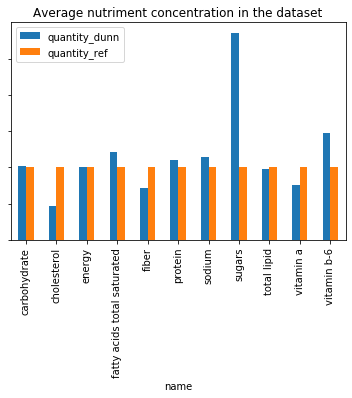

In [67]:
fig,ax = plt.subplots(1)
avg_soup_df.plot.bar(ax = ax)
empty_string_labels = ['']*len(ax.get_yticklabels())
ax.set_yticklabels(empty_string_labels)
ax.set_title('Average nutriment concentration in the dataset')
fig.savefig('../results/soup.png')

<div class="alert alert-block alert-info">
As one can observe from the plot, hte data ends up in a really coherent scale: this motivates us to push the investigation further.
</div>

### Mass items nutriments

<div class="alert alert-block alert-info">
We analyze the items most bought in terms of mass: lets take a look at the most bought items
</div>

In [20]:
top_weight = tot_weight_nut_df.head(6)[['dunn_name','TOT_WEIGHT','nut_name']]
top_weight

,dunn_name,TOT_WEIGHT,nut_name
0,TROPICAL FRUIT BANANAS,568654.682640,"Banana, raw"
1,FLUID MILK PRODUCTS FLUID MILK WHITE ONLY,158279.390752,"Milk, whole"
2,SOFT DRINKS SFT DRNK 2 LITER BTL CARB INCL,107754.002557,"Soft drink, NFS"
3,ONIONS ONIONS SWEET (BULK&BAG),101229.260620,"Onions, mature, raw"
4,WATER - CARBONATED/FLVRD DRINK NON-CRBNTD DRNK...,55172.619526,Water chestnut
5,GRAPES GRAPES RED,46509.962904,"Grapes, raw, NS as to type"


<div class="alert alert-block alert-info">
The banana quantity looks oddly high, looking at the average weight of the article to see if the weight_parser failed might be useful
</div>

In [21]:
tot_weight_nut_df['avg_weight'] = tot_weight_nut_df.TOT_WEIGHT / tot_weight_nut_df.QUANTITY
avg_banana_weight = tot_weight_nut_df[tot_weight_nut_df.dunn_name == 'TROPICAL FRUIT BANANAS'].avg_weight.values[0]
print('Average weight of the banana article {} kg.'.format(avg_banana_weight))

Average weight of the banana article 18.001667752688977 kg.


<div class="alert alert-block alert-info">
This definitely looks odd, but as the following plot, there are a lot of times where the banana article is sold with 40 LB (pounds)~ 18kg. The parser did well. 
</div>

In [22]:
food_transaction_data[food_transaction_data.dunn_name.str.contains('TROPICAL FRUIT BANANAS')].CURR_SIZE_OF_PRODUCT.value_counts()

40 LB    30207
8 OZ       197
            26
Name: CURR_SIZE_OF_PRODUCT, dtype: int64

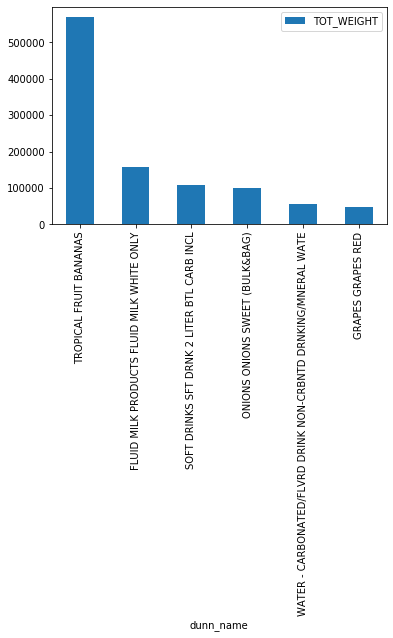

In [23]:
top_weight.plot.bar(x = 'dunn_name',y = 'TOT_WEIGHT')

In [24]:
def plot_nutriments(nut_indx,df,ax = None,sub_title = None):
    if ax is None:
        fig,ax = plt.subplots(1,figsize = (20,5))
    nutriment = nutriments[nut_indx]
    temp = df.sort_values(by = 'TOT_WEIGHT',ascending = False).reset_index().head(300)
    sns.barplot(x = temp.index,y = temp[nutriment],ax = ax)
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    title = nutriment
    ax.set_title(title)
    ax.set_ylabel('%s %s per 100 grams' % (nutriment,unit))
    ax.set_xlabel('items (sorted by most bought mass)')
    empty_string_labels = ['']*len(ax.get_xticklabels())
    ax.set_xticklabels(empty_string_labels)

In [25]:
plot_tot_nut = lambda indx: plot_nutriments(indx,tot_weight_nut_df)
interact(plot_tot_nut, indx=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='indx', max=16), Output()), _dom_classes=('widget-interac…

In [26]:
tot_weight_nut_df.to_pickle('../saved_data/tot_weight_nut_df.pickle')

<div class="alert alert-block alert-info">
Some article look like outliers in the cholesterol an polyunsaturated items. Let's investigate
</div>

In [27]:
#cholesterol
tot_weight_nut_df.head(300)[tot_weight_nut_df.cholesterol > 250]

/home/ymentha/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,dunn_name,TOT_WEIGHT,QUANTITY,DEPARTMENT,dunn_ingredients,nut_name,nut_ingredients,alcohol,carbohydrate,cholesterol,...,tot_sodium,tot_sugars,tot_total lipid,tot_vitamin a,tot_vitamin b-12,tot_vitamin b-6,tot_vitamin e,tot_vitamin k,tot_alcohol,avg_weight
122,EGGS EGGS - MEDIUM,2960.102523,5416,GROCERY,"[egg, medium]","Egg, whole, raw",[egg],0.0,0.72,372.0,...,420334.558337,1095.237934,28150.574998,473616.40376,2634.491246,503.217429,0.0,888.030757,0.0,0.546548


In [28]:
#fatty acids total polyunsaturated
tot_weight_nut_df.head(300)[tot_weight_nut_df['fatty acids total polyunsaturated'] > 20]

/home/ymentha/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,dunn_name,TOT_WEIGHT,QUANTITY,DEPARTMENT,dunn_ingredients,nut_name,nut_ingredients,alcohol,carbohydrate,cholesterol,...,tot_sodium,tot_sugars,tot_total lipid,tot_vitamin a,tot_vitamin b-12,tot_vitamin b-6,tot_vitamin e,tot_vitamin k,tot_alcohol,avg_weight
43,MARGARINES MARGARINE: TUBS AND BOWLS,7462.705370,10154,GROCERY,"[margarin, tub, bowl]","Margarine, tub, unsalted","[margarin, tub, unsalt]",0.0,0.75,0.0,...,2.089558e+05,0.0,598285.089537,6.111956e+06,597.016430,0.000000,0.0,684330.082457,0.0,0.734952
123,MARGARINES MARGARINE STICK,2949.708776,6495,GROCERY,[margarin],"Margarine, NFS","[margarin, nf]",0.0,0.86,1.0,...,1.988104e+06,0.0,176422.081893,2.415811e+06,0.000000,11061.407910,0.0,298805.499009,0.0,0.454151
161,SHORTENING/OIL CANOLA OILS,2083.801648,1427,GROCERY,"[canola, oil]",Canola and soybean oil,"[canola, soybean, oil]",0.0,0.00,0.0,...,0.000000e+00,0.0,208380.164800,0.000000e+00,0.000000,0.000000,0.0,289440.048907,0.0,1.460267
259,SPICES & EXTRACTS TABLE SALT POPCORN SALTICE C,952.161356,1308,GROCERY,"[tabl, salt, popcorn, saltic]","Margarine, stick, salted","[margarin, salt]",0.0,0.70,0.0,...,7.150732e+05,0.0,76848.943033,7.798202e+05,95.216136,8.569452,0.0,88551.006096,0.0,0.727952


<div class="alert alert-block alert-info">
Eggs and margarine/canola oil head out as outliers for cholesterol and fatty acids respectively. However, we don't know yet how much of the total quantity they represent: we investigate it in the following section.
</div>

#### Most relevant items per nutriments

<div class="alert alert-block alert-info">
Now we highlight the most responsible items for the sold mass of a given nutriment, in order to infere where people mainly take their nutriment income from.
</div>

In [29]:
def g(x):
    nutriment = nutriments[x]
    temp = tot_weight_nut_df.sort_values(by = 'tot_' + nutriment,ascending = False)[['TOT_WEIGHT','dunn_name','nut_name','tot_' + nutriment,nutriment]].head(6)
    print('#'*50 + nutriment.upper() + ' TOP NUTRIMENTS' + '#'*50)
    temp.plot.bar(x = 'dunn_name',y = 'tot_' + nutriment)
    return temp
interact(g, x=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=16), Output()), _dom_classes=('widget-interact',…

In [30]:
tot_weight_nut_df[tot_nutriments].sum().to_pickle('../saved_data/total_mass_nutrients.pickle')

<div class="alert alert-block alert-info">
A few things sets out of this plots:
    
* Cholesterol: The dairy represent a big part of the cholesterol presence in total food consumption, with eggs and meat. Even if the eggs have about 30x more cholesterol than the milk, the quantity of milk overpasses by a similar factor the one of the eggs, which  makes them reach a similar score.
* Energy: the bananas represent an overwhelming majority of the energy consumption: this result has to bet taken with some distance, as we saw earlier that the supermarket could do some reselling. Yet, we can see that the main sources of energy are indeed sweet and fatty articles.
* The sodium consumption might be higher in real life, as no salt article is present in the top 5.
</div>

### Number items nutriments

<div class="alert alert-block alert-info">
We analyze the items most bought in terms of counts: lets take a look at the most bought items
</div>

In [31]:
tot_sells_nut_df.head(5)[['dunn_name','QUANTITY','nut_name']]

,dunn_name,QUANTITY,nut_name
0,FLUID MILK PRODUCTS FLUID MILK WHITE ONLY,91449,"Milk, whole"
1,YOGURT YOGURT NOT MULTI-PACKS,65544,Yogurt dressing
2,SOFT DRINKS SOFT DRINKS 12/18&15PK CAN CAR,54983,"Soft drink, NFS"
3,SOFT DRINKS SFT DRNK 2 LITER BTL CARB INCL,54400,"Soft drink, NFS"
4,CHEESE SHREDDED CHEESE,35245,"Cheese, NFS"


### Demographic nutriments

<div class="alert alert-block alert-info">
The next idea is to check whether the nutrition profile does vary significantly across demographic features such as the income.
</div>

In [32]:
#get the nutriments amounts per article for each household
demo_nut_df = house_nut_df.copy()
demo_nut_df[nutriments] = demo_nut_df[nutriments].multiply(demo_nut_df.TOT_WEIGHT,axis = 0)  
demo_nut_df = demo_nut_df.drop(columns = ['dunn_name','dunn_ingredients','nut_name','nut_ingredients'])\
                                .groupby('household_key')\
                                .agg('sum')

demo_nut_df = demo_nut_df.join(hh_demographic_df.set_index('household_key'),how = 'inner')

#we average on the total amount of food consumed
demo_nut_df[nutriments] = demo_nut_df[nutriments].div(demo_nut_df.TOT_WEIGHT,axis = 0)

#### Income nutriments

In [33]:
income_nut_df = demo_nut_df.copy()

#check that we treat all the cases
income_nut_df[~income_nut_df.INCOME_DESC.str.contains('^[0-9]{2,3}-[0-9]{2,3}K$|Under 15K|250K+',regex = True)]

,TOT_WEIGHT,alcohol,carbohydrate,cholesterol,energy,fatty acids total monounsaturated,fatty acids total polyunsaturated,fatty acids total saturated,fiber,protein,...,tot_vitamin e,tot_vitamin k,tot_alcohol,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,,,,,,,,,,,,,,,


In [34]:
lower_numb = income_nut_df[income_nut_df.INCOME_DESC.str.contains('Under 15K')].shape[0]
higher_numb = income_nut_df[income_nut_df.INCOME_DESC.str.contains('250K+')].shape[0]
tot_num = income_nut_df.shape[0]
print('Extreme poor represent %.2f of the dataset.' % (lower_numb / tot_num))
print('Extreme wealhty represent %.2f of the dataset.' % (higher_numb / tot_num))

income_nut_df[['low_lim','high_lim']] = income_nut_df.INCOME_DESC.str.extract(r'^(\d{2,3})-(\d{2,3})K$')
income_nut_df.dropna(inplace = True)
income_nut_df[['low_lim','high_lim']] = income_nut_df[['low_lim','high_lim']].astype(int)
income_nut_df['av_income'] = (income_nut_df.low_lim + income_nut_df.high_lim).div(2)
income_nut_df.sort_values('av_income',inplace = True)
med = income_nut_df.av_income.median()
poors_df = income_nut_df[income_nut_df.av_income < med]
wealthy_df = income_nut_df[income_nut_df.av_income >= med]

print('Number of poor households: {}'.format(poors_df.shape[0]))
print('Number of wealthy households: {}'.format(wealthy_df.shape[0]))

Extreme poor represent 0.08 of the dataset.
Extreme wealhty represent 0.01 of the dataset.
Number of poor households: 323
Number of wealthy households: 406


<div class="alert alert-block alert-info">
The number of households is decently distributed across the 2 categories, and dropping the extremes is reasonable as their proportion is neglectable.
</div>

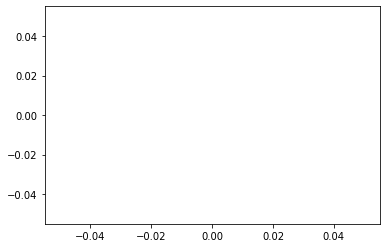

In [35]:
sns.lineplot([0],[0],alpha = 0)

In [71]:
def plot2nut(nut_indx,df1,df2,lims = None):
    nutriment = nutriments[nut_indx]
    ttest = stats.ttest_ind(poors_df[nutriment], wealthy_df[nutriment], equal_var = False,)
    pval = np.round(ttest[1],3)
    fig, ax = plt.subplots(1,figsize = (20,5))
    sns.distplot(df1[nutriment],norm_hist = True,ax = ax,label = 'low income')
    sns.distplot(df2[nutriment],norm_hist = True,ax = ax,label = 'high income')
    sns.lineplot([0],[0],alpha = 0,label = 'pvalue:' + str(pval))
    ax.set_title(nutriment,fontsize = 25)
    ax.legend()
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    ax.set_xlabel(unit + ' of ' + nutriment + ' /100g. of food',fontsize = 20)
    ax.set_ylabel('proportion of people',fontsize = 20)
    plt.legend(fontsize='xx-large', title_fontsize='40')

    if lims is not None:
        ax.set_xlim(lims)
        plt.rc('figure', titlesize=12)  
        plt.legend(fontsize='xx-large', title_fontsize='40')        
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        plt.savefig('../results/' + nutriment.replace(" ","_") + '_pvalue.png')
    print('Pvalue of different means: {}'.format(ttest[1]))
    
plot_tot_nut = lambda indx: plot2nut(indx,poors_df,wealthy_df)
interact(plot_tot_nut, indx=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='indx', max=16), Output()), _dom_classes=('widget-interac…

Pvalue of different means: 0.004955558468053155
Pvalue of different means: 0.006083461332628248
Pvalue of different means: 0.017315133892777387
Pvalue of different means: 0.011395208893132561


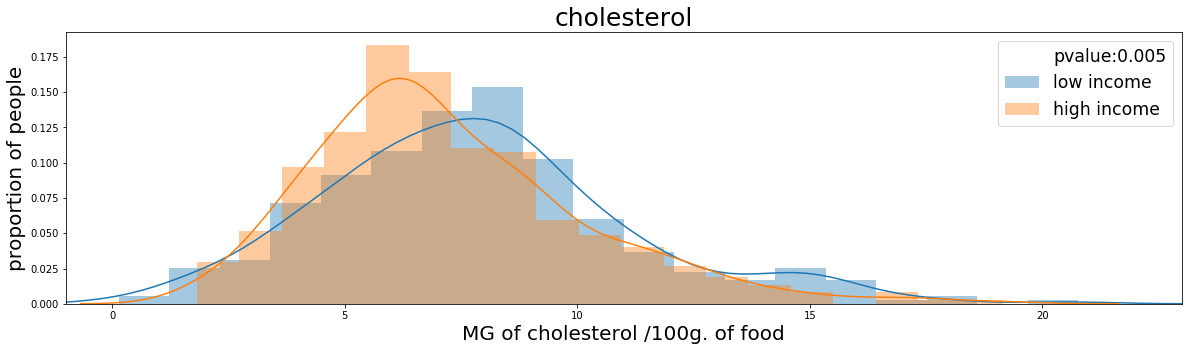

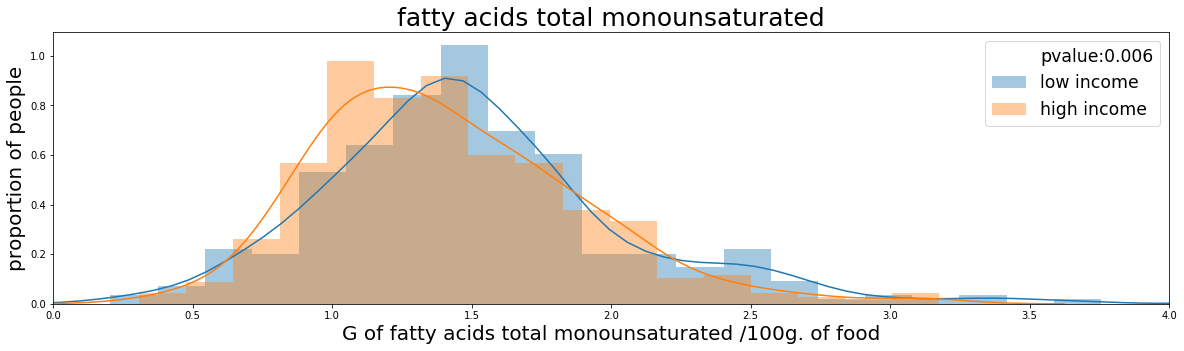

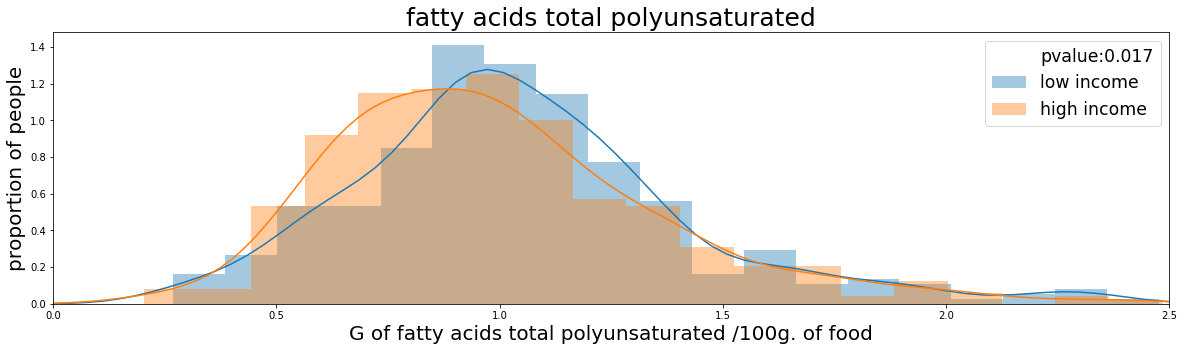

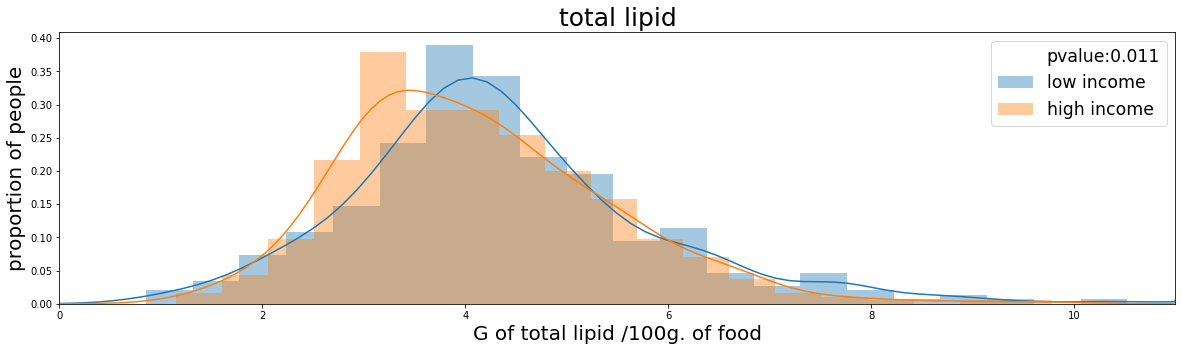

In [72]:
#saving interesting figures for the report
plot2nut(1,poors_df,wealthy_df,(-1,23))
plot2nut(3,poors_df,wealthy_df,(0,4))
plot2nut(4,poors_df,wealthy_df,(0,2.5))
plot2nut(10,poors_df,wealthy_df,(0,11))

In [38]:
poors_df.to_pickle('../saved_data/poors_df.pickle')
wealthy_df.to_pickle('../saved_data/wealthy_df.pickle')

<div class="alert alert-block alert-info">
It looks like the nutriments which change significantly across the income are the fatty acids in general and the cholesterol.
</div>

#### Age nutriments

In [39]:
demo_nut_df.AGE_DESC = demo_nut_df.AGE_DESC.astype('category')
dic_age = {'19-24':'19-34','25-34':'19-34','55-64':'55-65+','65+':'55-65+'}
demo_nut_df.AGE_DESC = demo_nut_df.AGE_DESC.map(dic_age).fillna(demo_nut_df.AGE_DESC)

demo_nut_df.groupby('AGE_DESC').count()

,TOT_WEIGHT,alcohol,carbohydrate,cholesterol,energy,fatty acids total monounsaturated,fatty acids total polyunsaturated,fatty acids total saturated,fiber,protein,...,tot_vitamin b-6,tot_vitamin e,tot_vitamin k,tot_alcohol,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
AGE_DESC,,,,,,,,,,,,,,,,,,,,,
19-34,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188
35-44,194,194,194,194,194,194,194,194,194,194,...,194,194,194,194,194,194,194,194,194,194
45-54,288,288,288,288,288,288,288,288,288,288,...,288,288,288,288,288,288,288,288,288,288
55-65+,131,131,131,131,131,131,131,131,131,131,...,131,131,131,131,131,131,131,131,131,131


<div class="alert alert-block alert-info">
The samples are evenly split across age categories.
</div>

In [40]:
uniques = np.sort(demo_nut_df.AGE_DESC.unique())
age_cat_dfs = []
for i in uniques:
    age_cat_dfs.append(demo_nut_df[demo_nut_df.AGE_DESC == i])

In [41]:
def plotages(nut_indx,dfs):
    fig, ax = plt.subplots(1,figsize = (20,5))
    nutriment = nutriments[nut_indx]
    for df in dfs:
        sns.distplot(df[nutriment],norm_hist = True,ax = ax,label = df.iloc[0].AGE_DESC)
    ax.set_title(nutriment)
    ax.legend()
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    ax.set_xlabel(unit + ' of ' + nutriment + ' /100g. of food')
    ax.set_ylabel('proportion of people')
    
plot_tot_ages = lambda indx: plotages(indx,age_cat_dfs)
interact(plot_tot_ages, indx=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='indx', max=16), Output()), _dom_classes=('widget-interac…

<div class="alert alert-block alert-info">
One intersting characteristic of this plot is the trend to consume more fibers as the age increases.
</div>

### Average nutriments consumption

In [120]:
demo2 = demo_nut_df[nutriments].copy()

In [121]:
short_cols = ['carbohydrate', 'cholesterol', 'energy',
       'F.A. tot monounsat.',
       'F.A. tot polyunsat', 'F.A total sat',
       'fiber', 'protein', 'sodium', 'sugars', 'total lipid', 'vitamin a',
       'vitamin b-12', 'vitamin b-6', 'vitamin e', 'vitamin k', 'alcohol']
demo2.columns = short_cols
all_nut2 = all_nutrition[nutriments].copy()
all_nut2.columns = short_cols
short_cols_rearrang = ['vitamin a','cholesterol', 'protein', 'sodium',
       'vitamin b-12','vitamin k',
       'F.A. tot polyunsat', 'F.A. tot monounsat.','F.A total sat', 'total lipid','energy','carbohydrate',
        'sugars', 'vitamin e', 'alcohol', 
        'vitamin b-6','fiber']
demo2 = demo2[short_cols_rearrang]
all_nut2 = all_nut2[short_cols_rearrang]

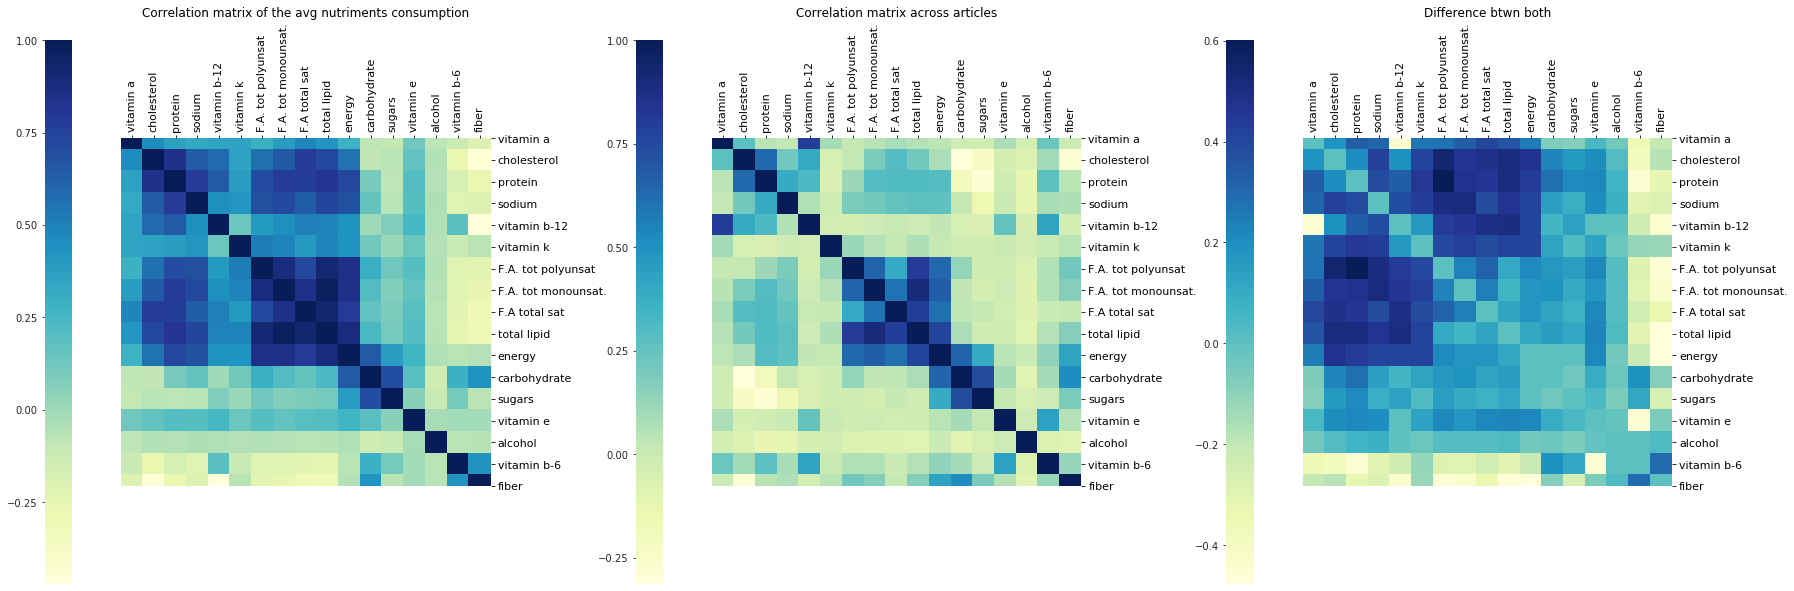

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [122]:
def plot_corr_mat(corrmat,title,ax):
    plt.figure()
    with sns.axes_style("white"):
        sns.heatmap(corrmat,\
                          cbar_kws = dict(use_gridspec=False,location="left"), \
                          xticklabels=True,yticklabels=True,\
                          #mask=mask,\
                          cmap="YlGnBu",square=True,\
                          ax = ax)
        ax.xaxis.set_ticks_position('top')
        ax.yaxis.set_ticks_position('right')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize = 11)
        ax.set_yticklabels(ax.get_xticklabels(),rotation=0,fontsize = 11)
        ax.set_title(title)

corrmat_hseholds = demo2.corr()
corrmat_food = all_nut2.corr()
fig,axes = plt.subplots(1,3,figsize = (30,10))
plot_corr_mat(corrmat_hseholds,'Correlation matrix of the avg nutriments consumption',axes[0])
plot_corr_mat(corrmat_food,'Correlation matrix across articles',axes[1])
plot_corr_mat(corrmat_hseholds - corrmat_food,'Difference btwn both',axes[2])
fig.savefig('../results/consumption_nutriments_correlation.png')

Correlations between the average nutritional intake of each household


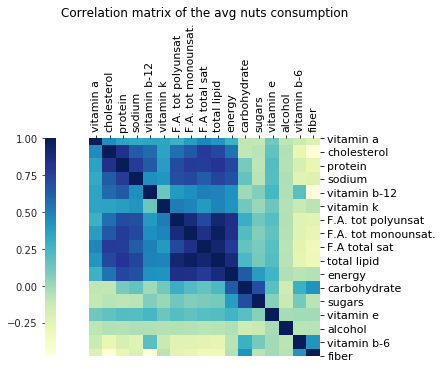

<Figure size 432x288 with 0 Axes>

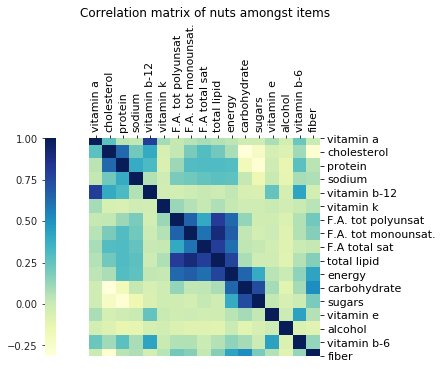

<Figure size 432x288 with 0 Axes>

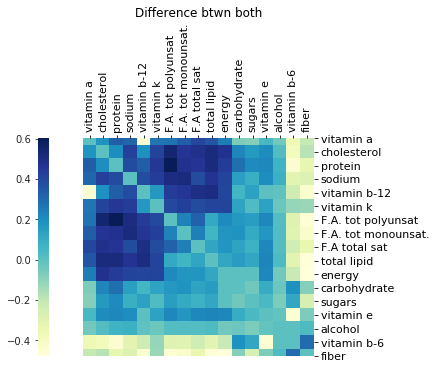

<Figure size 432x288 with 0 Axes>

In [123]:
fig,ax = plt.subplots(1)
plot_corr_mat(corrmat_hseholds,'Correlation matrix of the avg nuts consumption',ax)
fig.savefig('../results/corr1.png')

fig,ax = plt.subplots(1)
plot_corr_mat(corrmat_food,'Correlation matrix of nuts amongst items',ax)
fig.savefig('../results/corr2.png')

fig,ax = plt.subplots(1)
plot_corr_mat(corrmat_hseholds - corrmat_food,'Difference btwn both',ax)
fig.savefig('../results/corr3.png')

print('Correlations between the average nutritional intake of each household')

<div class="alert alert-block alert-info">
We see that the sodium tends to be more consumed in association with lipids, and so does protein. Interestingly, the cholesterol does not seem to have a strong correlation with other lipids amongst food items,but gets associated in food consumption.
</div>

In [106]:
all_nutrition.sort_values('vitamin b-12',ascending = False)

,DEPARTMENT,dunn_name,dunn_ingredients,nut_name,nut_ingredients,alcohol,carbohydrate,cholesterol,energy,fatty acids total monounsaturated,...,fiber,protein,sodium,sugars,total lipid,vitamin a,vitamin b-12,vitamin b-6,vitamin e,vitamin k
PRODUCT_ID,,,,,,,,,,,,,,,,,,,,,
905476,MEAT,BEEF VARIETY MEAT - INTERNAL,"[varieti, meat, intern]","Stewed variety meats, Puerto Rican style (most...","[stew, varieti, meat, puerto, rican, style, mo...",0.0,5.70,201.0,110.0,0.514,...,1.0,15.78,338.0,1.91,2.48,3669.0,27.45,0.487,0.0,4.8
895966,MEAT,BEEF VARIETY MEAT - EXTERNAL,"[varieti, meat, extern]","Stewed variety meats, Puerto Rican style (most...","[stew, varieti, meat, puerto, rican, style, mo...",0.0,5.70,201.0,110.0,0.514,...,1.0,15.78,338.0,1.91,2.48,3669.0,27.45,0.487,0.0,4.8
924563,MEAT,BEEF VARIETY MEAT - CUBE/STW/STRP,"[varieti, meat, cube, stw, strp]","Stewed variety meats, Puerto Rican style (most...","[stew, varieti, meat, puerto, rican, style, mo...",0.0,5.70,201.0,110.0,0.514,...,1.0,15.78,338.0,1.91,2.48,3669.0,27.45,0.487,0.0,4.8
843030,MEAT,PORK VARIETY MEAT - EXTERNAL,"[varieti, meat, extern]","Stewed variety meats, Puerto Rican style (most...","[stew, varieti, meat, puerto, rican, style, mo...",0.0,5.70,201.0,110.0,0.514,...,1.0,15.78,338.0,1.91,2.48,3669.0,27.45,0.487,0.0,4.8
1034258,MEAT,PORK VARIETY MEAT - INTERNAL,"[varieti, meat, intern]","Stewed variety meats, Puerto Rican style (most...","[stew, varieti, meat, puerto, rican, style, mo...",0.0,5.70,201.0,110.0,0.514,...,1.0,15.78,338.0,1.91,2.48,3669.0,27.45,0.487,0.0,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821557,NUTRITION,JUICE NON-CARB JCE(OVER 50% JCE),"[non, carb, jce]","Beer, low carb","[beer, low, carb]",3.3,0.73,0.0,27.0,0.000,...,0.0,0.17,3.0,0.00,0.00,0.0,0.00,0.000,0.0,0.0
1032551,DELI,SERVICE BEVERAGE SV BEV: CARB BEVERAGE,"[bev, carb, beverag]","Beer, low carb","[beer, low, carb]",3.3,0.73,0.0,27.0,0.000,...,0.0,0.17,3.0,0.00,0.00,0.0,0.00,0.000,0.0,0.0
872278,DELI,SERVICE BEVERAGE SV BEV: N/CARB FLV FRK/MINWTR,"[bev, carb, flv, frk, minwtr]","Beer, low carb","[beer, low, carb]",3.3,0.73,0.0,27.0,0.000,...,0.0,0.17,3.0,0.00,0.00,0.0,0.00,0.000,0.0,0.0


### Unhealthy households detection

In [43]:
hshold_dtction_df = house_nut_df.groupby('household_key')\
                                .agg(sum)\
                                .drop(columns = nutriments)
hshold_dtction_df[tot_nutriments] = hshold_dtction_df[tot_nutriments].div(hshold_dtction_df.TOT_WEIGHT, axis = 0)
#at that stage the to_nutriments have the average amount of nutrients
hshold_dtction_df = hshold_dtction_df.rename(columns= lambda x: 'avg_' + x[4:] if x in tot_nutriments else x )
avg_nutriments = ['avg_' + x[4:] for x in tot_nutriments]

In [44]:
hshold_dtction_df

,TOT_WEIGHT,avg_carbohydrate,avg_cholesterol,avg_energy,avg_fatty acids total monounsaturated,avg_fatty acids total polyunsaturated,avg_fatty acids total saturated,avg_fiber,avg_protein,avg_sodium,avg_sugars,avg_total lipid,avg_vitamin a,avg_vitamin b-12,avg_vitamin b-6,avg_vitamin e,avg_vitamin k,avg_alcohol
household_key,,,,,,,,,,,,,,,,,,
1,1606.746420,20.815562,4.917450,122.458164,1.384499,1.026762,1.143105,2.064636,2.668062,109.498900,10.571646,3.904766,24.654844,0.096988,0.247440,0.009265,4.218103,0.005290
2,508.592667,18.883603,6.762635,116.889942,1.342661,0.888658,1.201999,1.334151,2.749659,128.867910,11.188504,3.775203,31.323143,0.195706,0.159276,0.015712,5.552212,0.018652
3,963.064393,20.644436,6.537102,128.600300,1.509795,1.040541,1.194156,1.342363,3.308447,165.907171,10.927924,4.154663,32.745463,0.248729,0.180544,0.010934,4.238553,0.004663
4,114.247721,32.782862,16.028504,252.944056,3.558397,2.430715,3.442074,1.575531,7.451220,433.697168,8.412288,10.417785,62.285841,0.596770,0.272482,0.443764,8.199564,0.000000
5,116.519451,16.455747,14.629272,153.545850,2.840278,1.676429,2.524711,0.979186,5.137048,239.131321,8.585700,7.708151,45.049339,0.790091,0.756571,0.037928,4.063546,0.049748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,990.618807,17.750076,8.999959,141.074078,2.404298,1.759908,1.834523,1.536677,3.968632,176.278972,8.557939,6.488790,48.708130,0.192999,0.188987,0.007715,6.944614,0.023041
2497,2273.762535,18.949801,9.284302,133.362753,1.766678,1.608930,1.316996,1.777558,3.758502,210.422348,7.190581,5.092596,51.731374,0.212867,0.203798,0.007680,8.945849,0.002916
2498,839.468760,18.392436,7.295885,123.894018,1.569172,1.024291,1.594036,1.403954,3.122829,126.549856,8.863026,4.635154,37.001936,0.253028,0.191620,0.027643,3.711893,0.029840


In [45]:
hshold_dtction_df[avg_nutriments] = hshold_dtction_df[avg_nutriments].multiply((2000 / hshold_dtction_df.avg_energy),axis = 0)

In [46]:
quantiles = hshold_dtction_df.quantile((0.25,0.75))[avg_nutriments].T

quantiles['high_lim'] = (quantiles[0.75] - quantiles[0.25]) * 1.5 + quantiles[0.75]

quantiles['low_lim'] = quantiles[0.25] - (quantiles[0.75] - quantiles[0.25]) * 1.5
quantiles = quantiles.T.to_dict()

quantiles['avg_cholesterol']['high_lim']

234.15525322883852

In [47]:
ref_intakes_df = pd.read_csv('../data/health/ref_intakes.csv').drop(columns = ['unit_name'])

<div class="alert alert-block alert-info">
In order to detect outliers for a given nutriment, we use IQR range outlier detection.
</div>

In [48]:
def get_outliers(avg_nutriment,quantiles,df):
    """
    avg_nutriment: the nutriment for which we calculate an excess starting with string 'avg_'
    quantiles: the quantiles dictionary (for all nutriments)
    df: the dataframe linking the average nutriments consumptions to housholds ids
    """
    outliers_df = df[df[avg_nutriment] > quantiles[avg_nutriment]['high_lim']]
    return outliers_df.index

In [49]:
#list_outlier = get_outliers('tot_fatty acids total saturated',quantiles,hshold_dtction_df)
list_outlier = get_outliers('avg_cholesterol',quantiles,hshold_dtction_df)
list_outlier_df = hshold_dtction_df.loc[list_outlier]

In [50]:
hshold_dtction_df.to_pickle('../saved_data/hshold_dtction_df.pickle')
with open('../saved_data/avg_nutriments.pickle','wb') as f:
    pickle.dump(avg_nutriments,f)
with open('../saved_data/quantiles_outliers.pickle','wb') as f:
    pickle.dump(quantiles,f)

In [51]:
def plot_hshold(indx,hsholds):
    hshold_number = hsholds.index[indx]
    hshold = hsholds.iloc[indx]
    hshold_df = pd.DataFrame(hshold)
    hshold_df.columns = ['quantity']
    rename = lambda x: x[4:]
    hshold_df.rename(rename,inplace = True)
    ref_intakes_df = pd.read_csv('../data/health/ref_intakes.csv').drop(columns = ['unit_name'])
    fig,ax = plt.subplots(1)
    hshold_df.join(ref_intakes_df.set_index('name'),how = 'inner',lsuffix = '_original',rsuffix = '_optimal')\
                                 .plot.bar(ax = ax)
    ax.set_title(str(hshold_number) + ' house number')
    
_plot_hshold = lambda indx: plot_hshold(indx,list_outlier_df)
interact(_plot_hshold, indx=widgets.IntSlider(min=0, max=len(list_outlier_df) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='indx', max=81), Output()), _dom_classes=('widget-interac…

<div class="alert alert-block alert-info">
We now project the households on the 2 first PCs of the avg nutriments values
</div>

In [52]:
#We make sure we can use regular indexes for hsholds
np.all(hshold_dtction_df.index.values == np.arange(1,2501))

True

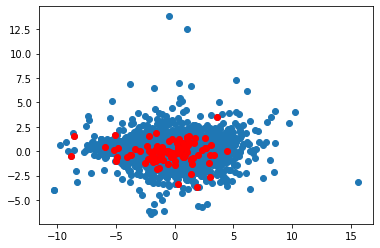

In [53]:
nutriment_data = hshold_dtction_df[avg_nutriments].values
nutriment_data = StandardScaler().fit_transform(nutriment_data)
pca = PCA(n_components=2)
pca.fit(nutriment_data)
nutriment_data = pca.transform(nutriment_data)
list_outlier = get_outliers('avg_protein',quantiles,hshold_dtction_df) -1

list_outlier = list_outlier -1
plt.scatter(nutriment_data[:,0],nutriment_data[:,1])
plt.scatter(nutriment_data[list_outlier][:,0],nutriment_data[list_outlier][:,1],c = 'r')

<div class="alert alert-block alert-info">
We now have a tool available to detect which houseold consume too much of certain nutriment: this could potentially be used in order to warn people whose consumption become dangerous and could harm them, allowing sensibilization about healthy food consumption.
</div>